In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import os
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [2]:
### Guideline for convenience ###
# 압축 풀기
!unzip -qq "animals10.zip"

'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [3]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?
image_path = 'Animals-10' 
animals = os.listdir(image_path)
animal_images_num = {}

for i in animals:
    animal_images_num[i] = len(os.listdir(image_path +'/'+ i))

animal_images_num


{'butterfly': 2112,
 'cat': 1668,
 'chicken': 3098,
 'cow': 1866,
 'dog': 4863,
 'elephant': 1446,
 'horse': 2623,
 'sheep': 1820,
 'spider': 4821,
 'squirrel': 1862}

In [4]:
# test에 넣을 이미지 개수 계산
test_animal_images_num = {}

for i in animals:
    test_animal_images_num[i] = int(animal_images_num[i]*0.3)
test_animal_images_num    

{'butterfly': 633,
 'cat': 500,
 'chicken': 929,
 'cow': 559,
 'dog': 1458,
 'elephant': 433,
 'horse': 786,
 'sheep': 546,
 'spider': 1446,
 'squirrel': 558}

In [7]:
# train, test 폴더 경로 선언 & 만들기
for i in range(10):
    os.makedirs('trainset/'+ animals[i])
    os.makedirs('testset/'+ animals[i])

train_path = 'trainset'
test_path = 'testset'

In [10]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기

# trainset으로 이동
for i in animals:
    a = os.listdir(image_path + '/' + i)[:-test_animal_images_num[i]]
    for j in a:
        shutil.move(image_path + '/' + i + '/' + j, 'trainset/' + i)

# testset으로 이동
for i in animals:
    a = os.listdir(image_path + '/' + i)[-test_animal_images_num[i]:]
    for j in a:
        shutil.move(image_path + '/' + i + '/' + j, 'testset/'+ i)        

# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [33]:
# # train, test 이미지를 위한 transforms function 정의
# # 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
# for i in range(10):
#     x = Image.open(train_path + '/'+ os.listdir(train_path)[i])
#     x = np.array(x)
#     print(os.listdir(train_path)[i],'의 shape: ',x.shape)

butterfly (562).jpeg 의 shape:  (225, 300, 3)
butterfly (50).jpeg 의 shape:  (300, 239, 3)
butterfly (362).jpg 의 shape:  (479, 640, 3)
butterfly (615).jpeg 의 shape:  (199, 300, 3)
butterfly (413).jpeg 의 shape:  (225, 300, 3)
butterfly (619).jpeg 의 shape:  (188, 300, 3)
butterfly (568).jpeg 의 shape:  (300, 281, 3)
butterfly (501).jpeg 의 shape:  (300, 300, 3)
butterfly (413).jpg 의 shape:  (426, 640, 3)
butterfly (365).jpg 의 shape:  (457, 640, 3)


In [2]:
# 보통 적용할 augmentation을 ToTensor, Normalize 전에 사용

train_transform = transforms.Compose([
    transforms.Resize(250),                 # 400으로 resize
    transforms.RandomCrop(224),             # 랜덤으로 330만큼 crop
    transforms.RandomHorizontalFlip(p=0.5), # 0.5 확률로 horizontal flip
    transforms.RandomRotation(20),          # 랜덤으로 20도 만큼 rotate
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(250),                 # 400으로 resize
    transforms.RandomCrop(224),             # 랜덤으로 330만큼 crop
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [3]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언
train_data = torchvision.datasets.ImageFolder(
    root = './trainset', # 바로 train 폴더 지정
    transform = train_transform # transform은 그냥 편의상 cifar에서 썼던거 그대로
)
test_data = torchvision.datasets.ImageFolder(
    root = './testset',
    transform = test_transform
)

In [4]:
print('train data 개수: ', len(train_data))
print('test data 개수: ', len(test_data))

train data 개수:  18331
test data 개수:  7848


In [5]:
print('이미지 사이즈: ', train_data[0][0].shape)

이미지 사이즈:  torch.Size([3, 224, 224])


In [6]:
print('첫번째 사진 label: ',train_data[0][1])
print('마지막 사진 label: ',train_data[-1][1])

첫번째 사진 label:  0
마지막 사진 label:  9


In [7]:
def imshow_loader(img):
    img = img * 0.225 + 0.456 # 정확한 값은 아니지만 대강 normalize 반대로
    img_np = np.array(img)
    imshow(np.transpose(img_np, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


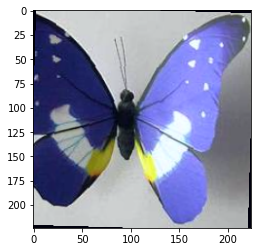

In [8]:
imshow_loader(train_data[0][0])

In [9]:
# train, test에 대해 DataLoader 정의
trainloader = DataLoader(
    train_data,
    batch_size = 64,      # 일반적으로 batch size = 16, 32
    shuffle=True,         # train dataloader는 epoch마다 데이터 다시 섞어서 batch 만들고 학습! - 학습 효율 up
    num_workers=2
)
testloader = DataLoader(
    test_data,
    batch_size = 64,      # 일반적으로 batch size = 16, 32
    shuffle=False,        # test dataloader는 데이터 매번 섞을 이유가 없음 - 어차피 확인 용도
    num_workers=2
)

In [10]:
### Model 클래스 정의 - 차원에 유의하자!
# 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# 가장 마지막 Linear의 out_features는 얼마로 해야할까?

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        ##### Layer 정의 #####
        self.layer = nn.Sequential(
            # 맨처음 RGB 채널 3개이므로 가장 처음 in_channels = 3
            # img의 가장 첫 차원이 batch_size 값은 계속해서 유지
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # [batch_size,3,224,224] -> [batch_size,16,224,224] 
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1), # [batch_size,8,224,224] -> [batch_size,16,224,224]
            nn.ReLU(),
            nn.Dropout(0.2), # 0.2 확률로 Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),                                # [batch_size,16,224,224] -> [batch_size,16,112,112]

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # [batch_size,16,112,112] -> [batch_size,32,112,112] 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # [batch_size,32,112,112] -> [batch_size,32,112,112] 
            nn.ReLU(),
            nn.Dropout(0.2), # 0.2 확률로 Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),                                # [batch_size,32,112,112] -> [batch_size,32,56,56] 

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # [batch_size,32,56,56]  -> [batch_size,64,56,56] 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # [batch_size,64,56,56]  -> [batch_size,64,56,56] 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # [batch_size,64,56,56]  -> [batch_size,64,56,56] 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                                 # [batch_size,64,56,56] -> [batch_size,64,28,28]

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # [batch_size,64,28,28] -> [batch_size,128,28,28]
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,28,28] -> [batch_size,128,28,28]
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,28,28] -> [batch_size,128,28,28]
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,28,28] -> [batch_size,128,28,28]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                                 # [batch_size,128,28,28] -> [batch_size,128,14,14]

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,14,14] -> [batch_size,128,14,14]
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,14,14] -> [batch_size,128,14,14]
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,14,14] -> [batch_size,128,14,14]
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # [batch_size,128,14,14] -> [batch_size,128,14,14]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)                                 # [batch_size,128,14,114] -> [batch_size,128,7,7]


        )
        self.fc_layer = nn.Sequential(
            nn.Linear(128*7*7,1000),                                                # [batch_size,32*5*5] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )

    def forward(self, x):
        # forward pass 과정
        out = self.layer(x)
        out = out.view(out.size(0),-1)  # FC layer에 들어가기전, flatten! - view 함수 활용
                                        # 가장 첫 차원인 batch_size는 유지하고 나머지 차원들을 하나로 합치기 - [batch_size,16,5,5] -> [batch_size,16*5*5]
        out = self.fc_layer(out)
        return out

In [11]:
# Device 선언 (GPU 권장)
device = device = torch.device('cuda')
device

device(type='cuda')

In [12]:
# torchsummary로 모델 차원 어떻게 나오는지 돌려보기

from torchsummary import summary
test_model = MyModel() # 모델 객체 선언
test_model.to(device)
summary(test_model, (3,224,224), batch_size=64) # Recall) Tensor는 C, H, W 순서로 이미지 가짐

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 224, 224]             448
              ReLU-2         [64, 16, 224, 224]               0
            Conv2d-3         [64, 16, 224, 224]           2,320
              ReLU-4         [64, 16, 224, 224]               0
           Dropout-5         [64, 16, 224, 224]               0
         MaxPool2d-6         [64, 16, 112, 112]               0
            Conv2d-7         [64, 32, 112, 112]           4,640
              ReLU-8         [64, 32, 112, 112]               0
            Conv2d-9         [64, 32, 112, 112]           9,248
             ReLU-10         [64, 32, 112, 112]               0
          Dropout-11         [64, 32, 112, 112]               0
        MaxPool2d-12           [64, 32, 56, 56]               0
           Conv2d-13           [64, 64, 56, 56]          18,496
             ReLU-14           [64, 64,

In [32]:
# 모델 객체 선언
mymodel = MyModel().to(device)
mymodel

MyModel(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Dropout(p=0.2, inplace=False)
    (19): MaxPool2d(kernel_size=2, str

In [33]:
# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0.01)

mymodel.apply(init_weights)

MyModel(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Dropout(p=0.2, inplace=False)
    (19): MaxPool2d(kernel_size=2, str

In [34]:
# loss func, optimizer 정의
criterion = nn.CrossEntropyLoss().to(device) # criterion (loss func)도 device 위에서
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.001, weight_decay=0.0001) # 보통 Adam의 learning rate로 0.001 사용
                                                                                  # weight_decay = L2 Regularization의 lambda값 (가중치 제한 정도)

In [35]:
with torch.no_grad():
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        print(inputs.shape)  # batch_size개의 이미지
        print(targets.shape) # batch_size개의 클래스

        outputs = mymodel(inputs)
        print(outputs.shape) # outputs는 32, 10 차원 (32개 data의 확률 10개씩)
        print(targets.shape) # targets는 32차원 (32개 data의 실제 클래스)

        loss = criterion(outputs, targets)  # -> cross entropy 식에 넣을때 이런 형태로 넣으면됨 (outputs, targets의 차원을 맞출 필요가 없음)
        print(loss.item())

        print(outputs.max(1)[1]) # 예측한 클래스
        print(targets) # 실제 클래스
        correct = (outputs.max(1)[1] == targets).sum().item() # 맞게 예측한 클래스 개수
        print(correct)
        break

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64])
2.3306093215942383
tensor([0, 6, 8, 6, 6, 0, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 8, 0, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 8, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6, 8,
        6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0], device='cuda:0')
tensor([6, 5, 6, 4, 7, 8, 8, 8, 2, 2, 7, 0, 2, 8, 4, 1, 5, 1, 1, 5, 9, 8, 0, 4,
        3, 0, 6, 2, 2, 2, 8, 3, 7, 5, 1, 4, 6, 5, 3, 3, 6, 2, 8, 5, 3, 4, 4, 6,
        8, 6, 4, 7, 5, 4, 8, 2, 4, 4, 4, 1, 4, 8, 4, 5], device='cuda:0')
4


In [36]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [37]:
# train 함수 정의
def train(epoch):
    print(f'\n[ Train epoch: {epoch+1} ]')

    mymodel.train() # train은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하고 진행하기 위함

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어줘야됨
        
        # DL 학습 기본 코드
        optimizer.zero_grad() # gradient 초기화
        outputs = mymodel(inputs) # 현재 batch의 inputs을 모델에 넣어 outputs 추출 (확률값)
        loss = criterion(outputs, targets) # 추출한 outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 300 == 299:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 300 batches: {running_loss / 300}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [38]:
# test 함수 정의
def test(epoch):
    print(f'\n[ Test epoch: {epoch+1} ]')

    mymodel.eval() # eval은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하지 않기 위함!
                   # ex. evaluation 할때는 Dropout 없이 지금까지 학습한 모든 node를 활용해서 진행해야됨

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = mymodel(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [39]:
# training
num_epoch = 100

for epoch in range(0, num_epoch):
    train(epoch)
    test(epoch)

# model 저장! - parameter값 저장
torch.save(mymodel.state_dict(), './mymodel.pt')
print('Model Saved!')


[ Train epoch: 1 ]

Total train accuarcy: 19.971632753259506
Total train loss: 2.256971460601594

[ Test epoch: 1 ]

Test accuarcy: 26.19775739041794
Test average loss: 2.167900951897226

[ Train epoch: 2 ]

Total train accuarcy: 34.804429654683325
Total train loss: 1.8987409063332588

[ Test epoch: 2 ]

Test accuarcy: 38.277268093781856
Test average loss: 1.8602917359127262

[ Train epoch: 3 ]

Total train accuarcy: 41.51982979651956
Total train loss: 1.6940067204864182

[ Test epoch: 3 ]

Test accuarcy: 32.3394495412844
Test average loss: 2.0030111990323882

[ Train epoch: 4 ]

Total train accuarcy: 44.760242212645245
Total train loss: 1.59894357034969

[ Test epoch: 4 ]

Test accuarcy: 43.374108053007134
Test average loss: 1.664057246068629

[ Train epoch: 5 ]

Total train accuarcy: 47.50422781081229
Total train loss: 1.5244442349111578

[ Test epoch: 5 ]

Test accuarcy: 42.38022426095821
Test average loss: 1.7248184225423548

[ Train epoch: 6 ]

Total train accuarcy: 49.1135235393

In [40]:
seq_train_loss

[2.256971460601594,
 1.8987409063332588,
 1.6940067204864182,
 1.59894357034969,
 1.5244442349111578,
 1.4754850025376376,
 1.4255422233289128,
 1.360636402713297,
 1.3202350191538341,
 1.27310889917799,
 1.2358165630480138,
 1.1877841567328582,
 1.1432928235273327,
 1.1381691683875559,
 1.087225626570007,
 1.0714712007951237,
 1.0543327815441303,
 1.034239369817727,
 1.003579410734077,
 0.9804636520375773,
 0.9667413078949426,
 0.946007309786534,
 0.9183696678706578,
 0.9071548884338618,
 0.9033242518062791,
 0.8771381041729491,
 0.8590100772081767,
 0.8550448631575714,
 0.8329921764571492,
 0.8070931235256926,
 0.8146945014855588,
 0.8071150359168701,
 0.7926095997207256,
 0.7810822354584206,
 0.7696989791318515,
 0.7598507327485168,
 0.7438319990028488,
 0.7405284010782475,
 0.7366029409373679,
 0.71789894681359,
 0.7039351727073616,
 0.7161230235149636,
 0.689090304985279,
 0.6878136932226839,
 0.6891625595217382,
 0.6663602040204437,
 0.6660160549010965,
 0.6577000040625861,
 0.65

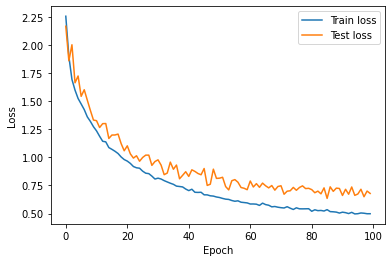

In [44]:
plt.plot(range(num_epoch), seq_train_loss, label="Train loss")
plt.plot(range(num_epoch), seq_test_loss, label="Test loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [45]:
seq_train_acc

[19.971632753259506,
 34.804429654683325,
 41.51982979651956,
 44.760242212645245,
 47.50422781081229,
 49.113523539359555,
 51.1646936882876,
 53.57590966122961,
 54.50875565981125,
 56.23806666302984,
 57.623697561507825,
 59.41301620206208,
 60.869565217391305,
 61.109595766733946,
 62.811630571163604,
 63.122579237357485,
 64.24635862746167,
 64.62822541050679,
 65.73563908133762,
 66.5702907642791,
 66.76122415580164,
 67.61769679777426,
 68.95968577818995,
 69.15061916971251,
 69.24881348535268,
 70.14347280562981,
 70.75445965850199,
 71.23997599694506,
 72.03644100158202,
 72.29283727019802,
 72.38012110632262,
 72.80562980743004,
 72.91473460258578,
 73.6402814903715,
 74.20762642518139,
 74.04942447220556,
 74.70950848289782,
 75.10228574545852,
 75.04773334788064,
 75.90966122961105,
 76.32971469096067,
 75.85510883203317,
 76.78795483061481,
 76.79341007037259,
 76.82614150891932,
 77.70989034968086,
 77.59533031476734,
 77.85718182314113,
 78.2990562435219,
 78.16813048933

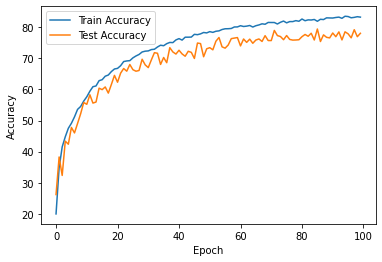

In [46]:
plt.plot(range(num_epoch), seq_train_acc, label="Train Accuracy")
plt.plot(range(num_epoch), seq_test_acc, label="Test Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()